# Crude Oil Price Estimation Using VADER Sentiment Analysis

In [2]:
from bs4 import BeautifulSoup as BS
import requests
import json
import time
import datetime

import pandas as pd
import numpy as np
import datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn           as sns
sns.set_style("darkgrid")
%matplotlib inline

## Article Extraction from New York Times

In [3]:
# Import New York Times API key from local computer drive
import os

app_id = '9615c816-2fac-4683-bca7-3b94d1958030' 

NEWS_KEY = os.getenv('NEWS_KEY')
api_key = NEWS_KEY

In [4]:
# Create function that requests articles with keywords "oil, petroleum, and energy"
def call_nyt_by_year_and_page(year, page):
    root_url   = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest'
    begin_date = '&begin_date={}0101'.format(str(year))
    end_date   = '&end_date={}1231'.format(str(year))
    pagination = '&page={}'.format(str(page))
    doc_params = '&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstract'
    
    url        = root_url + begin_date + end_date + pagination + doc_params + '&api-key=' + api_key
    print(url)
    
    response   = requests.get(url)
    
    return response.json()

In [5]:
# Create function that creates a list of urls for pages that contain the keywords per year
def call_nyt_by_year(year):
    annual_articles = []
    
    # find how many articles (hits) contain 'oil, petroleum, energy' in a calendar year
    total_results = call_nyt_by_year_and_page(year,0)
    hits  = total_results['response']['meta']['hits']
    
    # request all available pages
    # sleep 7 seconds to clear NYT API rate limit
    for i in range(int(hits/10)):
        query = call_nyt_by_year_and_page(year,i)
        annual_articles = annual_articles + query['response']['docs']
        time.sleep(7)
        
    return annual_articles

In [6]:
# Create function that combines all articles from all years in our range
def call_nyt_by_all_years(years):
    all_articles = []
    
    for year in years:
        annual_articles = call_nyt_by_year(year)
        all_articles = all_articles + annual_articles
        time.sleep(7)
        
    return all_articles



In [7]:
# Run function to create list of urls for selected years
all_years    = list(range(2010,2020))
all_articles = call_nyt_by_all_years(all_years)

https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest&begin_date=20100101&end_date=20101231&page=0&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstract&api-key=QQbF2aTVikDRZiYgV0atR9m5xR4z4eWX
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest&begin_date=20100101&end_date=20101231&page=0&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstract&api-key=QQbF2aTVikDRZiYgV0atR9m5xR4z4eWX
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest&begin_date=20100101&end_date=20101231&page=1&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstract&api-key=QQbF2aTVikDRZiYgV0atR9m5xR4z4eWX
https://api.nytimes.com/svc/search/v2/articlesearch.json?q=oil,petroleum,naturalgas,energy&sort=newest&begin_date=20100101&end_date=20101231&page=2&fl=web_url&fl=snippet&fl=pub_date&fl=_id&fl=lead_paragraph%&fl=abstra

KeyError: 'response'

In [7]:
# save and read JSON with raw API results
with open("nyt_api.json", "w") as write_file:
    json.dump(all_articles, write_file)
    
with open("nyt_api.json", "r") as read_file:
    data = json.load(read_file)

In [8]:
# web scrape NYT for all articles containing keywords using web URLs from API
# returns article content as string
def get_nyt_text(url):
    # get web URL HTML
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    page = requests.get(url, headers=headers,timeout=5)
    page.status_code
    
    # get article content from HTML
    soup = BS(page.content, 'html.parser')
    content = soup.findAll('p', class_ = 'css-18icg9x evys1bk0')
    
    nyt = ''
    for index in range(len(content)):
        nyt += content[index].get_text()
        
    return nyt

## VADER Sentiment Analysis

In [12]:
si = SentimentIntensityAnalyzer()

for i in range(len(data)):
    data[i]['VADER snippet neg']      = si.polarity_scores(data[i]['snippet'])['neg']
    data[i]['VADER snippet neu']      = si.polarity_scores(data[i]['snippet'])['neu']
    data[i]['VADER snippet pos']      = si.polarity_scores(data[i]['snippet'])['pos']
    data[i]['VADER snippet compound'] = si.polarity_scores(data[i]['snippet'])['compound']
    
#     data[i]['VADER lead neg']      = si.polarity_scores(data[i]['lead_paragraph'])['neg']
#     data[i]['VADER lead neu']      = si.polarity_scores(data[i]['lead_paragraph'])['neu']
#     data[i]['VADER lead pos']      = si.polarity_scores(data[i]['lead_paragraph'])['pos']
#     data[i]['VADER lead compound'] = si.polarity_scores(data[i]['lead_paragraph'])['compound']

In [17]:
data[0:3]

[{'abstract': 'It was a year full of big environmental news, from the BP oil spill to the failed climate bill.',
  'web_url': 'https://green.blogs.nytimes.com/2010/12/31/2010-an-untameable-spill-an-unpassable-bill/',
  'snippet': 'It was a year full of big environmental news, from the BP oil spill to the failed climate bill.',
  'pub_date': '2010-12-31T23:00:27+0000',
  '_id': 'nyt://article/6932d941-5087-54fd-a1ac-9b625bd96a6e',
  'article': '',
  'VADER snippet neg': 0.163,
  'VADER snippet neu': 0.837,
  'VADER snippet pos': 0.0,
  'VADER snippet compound': -0.5106},
 {'abstract': 'The first federal regulations on climate-altering gases from factories and power plants take effect on Sunday and set up a dangerous political clash for both sides.',
  'web_url': 'https://www.nytimes.com/2010/12/31/science/earth/31epa.html',
  'snippet': 'The first federal regulations on climate-altering gases from factories and power plants take effect on Sunday and set up a dangerous political clash fo

In [16]:
# save JSON with VADER results
with open("nyt_api_and_articles_vader_textblob.json", "w") as write_file:
    json.dump(data, write_file)

In [18]:
# count all web URLs where web scraping could not retrieve article content
null_articles = 0
full_articles = 0

for i in range(len(data)):
    
    if len(data[i]['article']) == 0:
        null_articles += 1
    else:
        full_articles += 1

KeyError: 'article'

In [80]:
# Create a dataframe with article content and VADER scores
sentiment = pd.DataFrame(data)
sentiment['date'] = pd.to_datetime(sentiment.pub_date).dt.date
# sentiment.head()

# turned dataframe to pickle file to save information
sentiment.to_pickle("sentiment_pickle.pkl")
sentiment = pd.read_pickle("sentiment_pickle.pkl")
sentiment.head()

In [61]:
# remove records where article content could not be retrieved from web URLs
# sentiment_clean = sentiment[sentiment['VADER snippet compound'] != 0]
# sentiment_clean.head()

abstract  \
0  It was a year full of big environmental news, ...   
1  The first federal regulations on climate-alter...   
2  About $11 billion in oil and natural gas trade...   
3  Recent years have been humbling for oil bulls,...   
4  Crude oil traded over $90 for a fifth consecut...   

                                             web_url  \
0  https://green.blogs.nytimes.com/2010/12/31/201...   
1  https://www.nytimes.com/2010/12/31/science/ear...   
2  https://www.nytimes.com/2010/12/31/business/gl...   
3  https://www.nytimes.com/2010/12/30/business/30...   
4  https://www.nytimes.com/2010/12/30/business/30...   

                                             snippet  \
0  It was a year full of big environmental news, ...   
1  The first federal regulations on climate-alter...   
2  About $11 billion in oil and natural gas trade...   
3  Recent years have been humbling for oil bulls,...   
4  Crude oil traded over $90 for a fifth consecut...   

                   pub_date  \
0  2010-12-31T23:00:27+0000   
1  2010-12-31T01:47:00+0000   
2  2010-12-30T20:21:30+0000   
3  2010-12-30T02:34:46+0000   
4  2010-12-29T14:06:12+0000   

                                                 _id article  \
0  nyt://article/6932d941-5087-54fd-a1ac-9b625bd9...           
1  nyt://article/3cc71f15-7131-58f9-b561-81115150...           
2  nyt://article/d8808e92-9912-50bf-b1f4-efd46aef...           
3  nyt://article/a3ab7378-223e-5c33-a8bd-48da47e0...           
4  nyt://article/8cf8d370-fd0b-5889-a8af-3745ada9...           

   VADER snippet neg  VADER snippet neu  VADER snippet pos  \
0              0.163              0.837              0.000   
1              0.114              0.886              0.000   
2              0.072              0.847              0.081   
3              0.000              0.868              0.132   
4              0.215              0.785              0.000   

   VADER snippet compound        date  
0                 -0.5106  2010-12-31  
1                 -0.4767  2010-12-31  
2                  0.0772  2010-12-30  
3                  0.5640  2010-12-30  
4                 -0.6369  2010-12-29

In [77]:
# vader_pickle = sentiment[sentiment['VADER snippet compound'] != 0]
# vader_pickle.to_pickle("vader_picke_file.pkl")

In [54]:
# id_column = sentiment['_id']
# id_column.head()
sentiment.columns

Index(['VADER snippet neg', 'VADER snippet neu', 'VADER snippet pos',
       'VADER snippet compound'],
      dtype='object')

In [58]:
# group articles by date to calculate average daily scores
sentiment_clean = sentiment_clean.groupby('date').mean()
sentiment_clean

VADER snippet neg  VADER snippet neu  VADER snippet pos  \
date                                                                  
2010-01-04              0.198             0.6500             0.1530   
2010-01-05              0.000             0.8070             0.1930   
2010-01-06              0.000             0.8980             0.1020   
2010-01-07              0.066             0.7020             0.2310   
2010-01-13              0.000             0.6785             0.3215   
...                       ...                ...                ...   
2019-12-05              0.135             0.7870             0.0790   
2019-12-11              0.000             0.6960             0.3040   
2019-12-12              0.264             0.6420             0.0950   
2019-12-17              0.000             0.8760             0.1240   
2019-12-24              0.051             0.8710             0.0770   

            VADER snippet compound  
date                                
2010-01-04                 -0.3818  
2010-01-05                  0.6369  
2010-01-06                  0.1531  
2010-01-07                  0.6124  
2010-01-13                  0.6564  
...                            ...  
2019-12-05                 -0.3612  
2019-12-11                  0.7178  
2019-12-12                 -0.7184  
2019-12-17                  0.4767  
2019-12-24                  0.1655  

[970 rows x 4 columns]

In [62]:
# get article counts by day
counts = sentiment_clean.groupby('date').count()
counts['article count'] = counts['_id']
counts = counts['article count']
counts

article count
date                     
2010-01-04              1
2010-01-05              1
2010-01-06              1
2010-01-07              1
2010-01-13              2
...                   ...
2019-12-05              1
2019-12-11              1
2019-12-12              1
2019-12-17              1
2019-12-24              1

[970 rows x 1 columns]

In [64]:
# group articles by date
sentiment_clean = sentiment_clean.groupby('date').mean()
sentiment_clean

VADER snippet neg  VADER snippet neu  VADER snippet pos  \
date                                                                  
2010-01-04              0.198             0.6500             0.1530   
2010-01-05              0.000             0.8070             0.1930   
2010-01-06              0.000             0.8980             0.1020   
2010-01-07              0.066             0.7020             0.2310   
2010-01-13              0.000             0.6785             0.3215   
...                       ...                ...                ...   
2019-12-05              0.135             0.7870             0.0790   
2019-12-11              0.000             0.6960             0.3040   
2019-12-12              0.264             0.6420             0.0950   
2019-12-17              0.000             0.8760             0.1240   
2019-12-24              0.051             0.8710             0.0770   

            VADER snippet compound  
date                                
2010-01-04                 -0.3818  
2010-01-05                  0.6369  
2010-01-06                  0.1531  
2010-01-07                  0.6124  
2010-01-13                  0.6564  
...                            ...  
2019-12-05                 -0.3612  
2019-12-11                  0.7178  
2019-12-12                 -0.7184  
2019-12-17                  0.4767  
2019-12-24                  0.1655  

[970 rows x 4 columns]

In [65]:
# Get number of articles per day
sentiment_counts = sentiment_clean.merge(counts, left_on='date', right_index=True)
sentiment_counts

VADER snippet neg  VADER snippet neu  VADER snippet pos  \
date                                                                  
2010-01-04              0.198             0.6500             0.1530   
2010-01-05              0.000             0.8070             0.1930   
2010-01-06              0.000             0.8980             0.1020   
2010-01-07              0.066             0.7020             0.2310   
2010-01-13              0.000             0.6785             0.3215   
...                       ...                ...                ...   
2019-12-05              0.135             0.7870             0.0790   
2019-12-11              0.000             0.6960             0.3040   
2019-12-12              0.264             0.6420             0.0950   
2019-12-17              0.000             0.8760             0.1240   
2019-12-24              0.051             0.8710             0.0770   

            VADER snippet compound  article count  
date                                               
2010-01-04                 -0.3818              1  
2010-01-05                  0.6369              1  
2010-01-06                  0.1531              1  
2010-01-07                  0.6124              1  
2010-01-13                  0.6564              2  
...                            ...            ...  
2019-12-05                 -0.3612              1  
2019-12-11                  0.7178              1  
2019-12-12                 -0.7184              1  
2019-12-17                  0.4767              1  
2019-12-24                  0.1655              1  

[970 rows x 5 columns]

In [66]:
# save dataframe information in pickle form
sentiment_counts.to_pickle("sentiment_counts.pkl")

In [67]:
# review final DataFrame
sentiment_counts = pd.read_pickle("sentiment_counts.pkl")
sentiment_counts.head()

VADER snippet neg  VADER snippet neu  VADER snippet pos  \
date                                                                  
2010-01-04              0.198             0.6500             0.1530   
2010-01-05              0.000             0.8070             0.1930   
2010-01-06              0.000             0.8980             0.1020   
2010-01-07              0.066             0.7020             0.2310   
2010-01-13              0.000             0.6785             0.3215   

            VADER snippet compound  article count  
date                                               
2010-01-04                 -0.3818              1  
2010-01-05                  0.6369              1  
2010-01-06                  0.1531              1  
2010-01-07                  0.6124              1  
2010-01-13                  0.6564              2

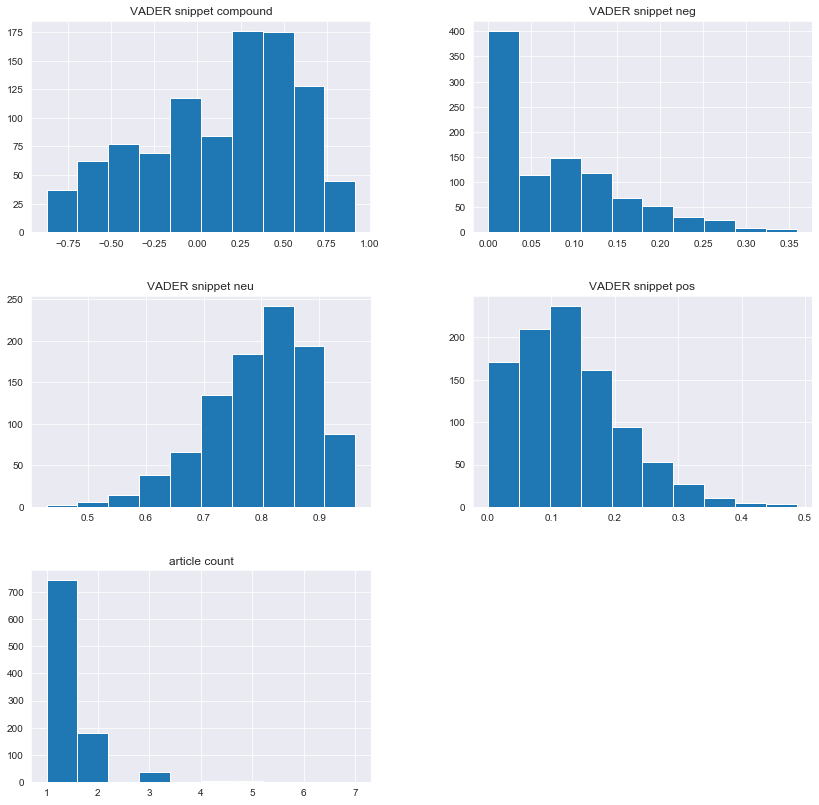

In [68]:
# plot statistical distributions of article sentiment
import matplotlib.pyplot as plt
axes = sentiment_counts.hist(figsize=(14,14))

In [8]:
# Extract sentiment analysis from pickle form
sentiment = pd.read_pickle("sentiment_pickle.pkl")
sentiment.head()

abstract  \
0  It was a year full of big environmental news, ...   
1  The first federal regulations on climate-alter...   
2  About $11 billion in oil and natural gas trade...   
3  Recent years have been humbling for oil bulls,...   
4  Crude oil traded over $90 for a fifth consecut...   

                                             web_url  \
0  https://green.blogs.nytimes.com/2010/12/31/201...   
1  https://www.nytimes.com/2010/12/31/science/ear...   
2  https://www.nytimes.com/2010/12/31/business/gl...   
3  https://www.nytimes.com/2010/12/30/business/30...   
4  https://www.nytimes.com/2010/12/30/business/30...   

                                             snippet  \
0  It was a year full of big environmental news, ...   
1  The first federal regulations on climate-alter...   
2  About $11 billion in oil and natural gas trade...   
3  Recent years have been humbling for oil bulls,...   
4  Crude oil traded over $90 for a fifth consecut...   

                   pub_date  \
0  2010-12-31T23:00:27+0000   
1  2010-12-31T01:47:00+0000   
2  2010-12-30T20:21:30+0000   
3  2010-12-30T02:34:46+0000   
4  2010-12-29T14:06:12+0000   

                                                 _id article  \
0  nyt://article/6932d941-5087-54fd-a1ac-9b625bd9...           
1  nyt://article/3cc71f15-7131-58f9-b561-81115150...           
2  nyt://article/d8808e92-9912-50bf-b1f4-efd46aef...           
3  nyt://article/a3ab7378-223e-5c33-a8bd-48da47e0...           
4  nyt://article/8cf8d370-fd0b-5889-a8af-3745ada9...           

   VADER snippet neg  VADER snippet neu  VADER snippet pos  \
0              0.163              0.837              0.000   
1              0.114              0.886              0.000   
2              0.072              0.847              0.081   
3              0.000              0.868              0.132   
4              0.215              0.785              0.000   

   VADER snippet compound        date  
0                 -0.5106  2010-12-31  
1                 -0.4767  2010-12-31  
2                  0.0772  2010-12-30  
3                  0.5640  2010-12-30  
4                 -0.6369  2010-12-29

In [9]:
# clean dataframe to show only date and sentiment compound score
sentiment_compound = sentiment.drop(columns=['abstract', 'web_url', 'snippet', 'pub_date', '_id', 'article', 'VADER snippet neg', 'VADER snippet neu', 'VADER snippet pos'])
sentiment_compound

VADER snippet compound        date
0                    -0.5106  2010-12-31
1                    -0.4767  2010-12-31
2                     0.0772  2010-12-30
3                     0.5640  2010-12-30
4                    -0.6369  2010-12-29
...                      ...         ...
1515                 -0.6705  2019-02-04
1516                  0.5994  2019-02-03
1517                  0.1027  2019-01-27
1518                  0.4215  2019-01-25
1519                  0.3353  2019-01-10

[1520 rows x 2 columns]

In [10]:
# import crude oil prices from csv
from pathlib import Path

crude_oil_path = "crude_oil.csv"
crude_oil_prices = pd.read_csv(crude_oil_path)

In [11]:
# set index as datetime
crude_oil_prices.set_index('date', inplace=True)
crude_oil_prices.index = pd.to_datetime(crude_oil_prices.index)

crude_oil_prices.head()

value
date              
2010-02-09   73.71
2010-02-10   74.48
2010-02-11   75.23
2010-02-12   74.11
2010-02-16   76.98

In [12]:
# get sentiment average per day
average_daily_sentiment = sentiment_compound.groupby('date').mean()
average_daily_sentiment['VADER avg'] = average_daily_sentiment['VADER snippet compound']
average_daily_sentiment = average_daily_sentiment[['VADER avg']]
average_daily_sentiment

VADER avg
date                 
2010-01-04   -0.38180
2010-01-05    0.31845
2010-01-06    0.15310
2010-01-07    0.61240
2010-01-13    0.65640
...               ...
2019-12-12   -0.71840
2019-12-13    0.00000
2019-12-16    0.00000
2019-12-17    0.47670
2019-12-24    0.16550

[1132 rows x 1 columns]

In [13]:
average_daily_sentiment.index = pd.to_datetime(average_daily_sentiment.index)
average_daily_sentiment.head()

VADER avg
date                 
2010-01-04   -0.38180
2010-01-05    0.31845
2010-01-06    0.15310
2010-01-07    0.61240
2010-01-13    0.65640

In [14]:
# sentiment_counts = sentiment_clean.merge(counts, left_on='date', right_index=True)
merged_df = crude_oil_prices.merge(average_daily_sentiment, left_index=True, right_index=True)

merged_df

value  VADER avg
date                         
2010-02-09  73.710   0.000000
2010-02-10  74.480   0.624900
2010-02-11  75.230   0.778300
2010-02-16  76.980   0.651767
2010-02-17  77.270   0.659700
...            ...        ...
2019-12-12  59.180  -0.718400
2019-12-13  60.070   0.000000
2019-12-16  60.196   0.000000
2019-12-17  60.912   0.476700
2019-12-24  61.110   0.165500

[903 rows x 2 columns]

## Prepare data to perform Random Tree Regression

In [15]:
# Set the 'train' data range for 8 years and the test for 2 years
train_start_date = merged_df.first_valid_index()
train_end_date = '2017-12-31'
test_start_date = '2018-01-01'
test_end_date = merged_df.last_valid_index()
train = merged_df.loc[train_start_date : train_end_date]
test = merged_df.loc[test_start_date:test_end_date]

In [16]:
# Created list from sentiment values for training data
sentiment_score_list = []
for date, row in train.T.iteritems():
    sentiment_score = np.asarray([merged_df.loc[date, 'VADER avg']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)

In [17]:
# Created list from sentiment values for testing data
sentiment_score_list = []
for date, row in test.T.iteritems():
    sentiment_score = np.asarray([merged_df.loc[date, 'VADER avg']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)

In [18]:
# Start train and test datasets with oil prices
y_train = pd.DataFrame(train[' value'])
y_test = pd.DataFrame(test[' value'])

In [31]:
pip install treeinterpreter

Note: you may need to restart the kernel to use updated packages.


In [19]:
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix

rf = RandomForestRegressor()
rf.fit(numpy_df_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
# Used predict function to calculate predicted crude oil prices
prediction, bias, contributions = ti.predict(rf, numpy_df_test)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Set index for predicted prices for test date range
test_date_index = merged_df.loc[test_start_date:test_end_date]
predictions_df = pd.DataFrame(data=prediction[0:], index = test_date_index.index, columns=['Prices'])

In [23]:
predictions_df

Prices
date                  
2018-01-18   66.895113
2018-01-19   50.336660
2018-01-30  102.305321
2018-02-01   80.477219
2018-02-05   78.264691
...                ...
2019-12-12   49.685568
2019-12-13   78.911828
2019-12-16   78.911828
2019-12-17   68.392923
2019-12-24   99.435100

[114 rows x 1 columns]

In [24]:
# Save predicted crude oil prices to pkl file
predictions_df.to_pickle("prediction_prices.pkl")

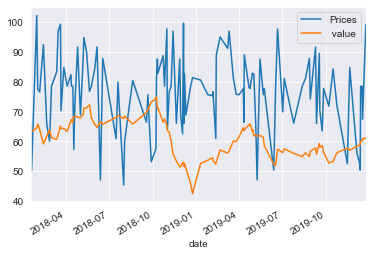

In [51]:
predictions_plot = predictions_df.plot()

fig = y_test.plot(ax = predictions_plot).get_figure()

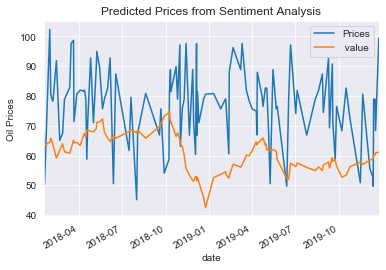

In [26]:
ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Predicted Prices from Sentiment Analysis')
ax.set_xlabel("Dates")
ax.set_ylabel("Oil Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("predicted_prices.png")

In [22]:
pip install backtesting

     |████████████████████████████████| 163kB 1.5MB/s eta 0:00:01
  Created wheel for backtesting: filename=Backtesting-0.1.2-cp37-none-any.whl size=157335 sha256=aaeda454ee364ebce54142ad407985485387fb4f8f12600eaa8fb119a472891b
  Stored in directory: /Users/jaime/Library/Caches/pip/wheels/f3/1e/b2/dfbe4dfb2ef3c35cb29f23059047acb31e1be0e82157f509cb
Successfully built backtesting
Note: you may need to restart the kernel to use updated packages.


In [23]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

//anaconda3/lib/python3.7/site-packages/backtesting/_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [26]:
SMA

<function backtesting.test.SMA(arr: pandas.core.series.Series, n: int) -> pandas.core.series.Series>

In [53]:
daily_changes = merged_df[' value'].pct_change()

In [54]:
merged_df['daily_changes'] = daily_changes
merged

value  VADER avg
date                         
2010-02-09  73.710   0.000000
2010-02-10  74.480   0.624900
2010-02-11  75.230   0.778300
2010-02-16  76.980   0.651767
2010-02-17  77.270   0.659700
...            ...        ...
2019-12-12  59.180  -0.718400
2019-12-13  60.070   0.000000
2019-12-16  60.196   0.000000
2019-12-17  60.912   0.476700
2019-12-24  61.110   0.165500

[903 rows x 2 columns]

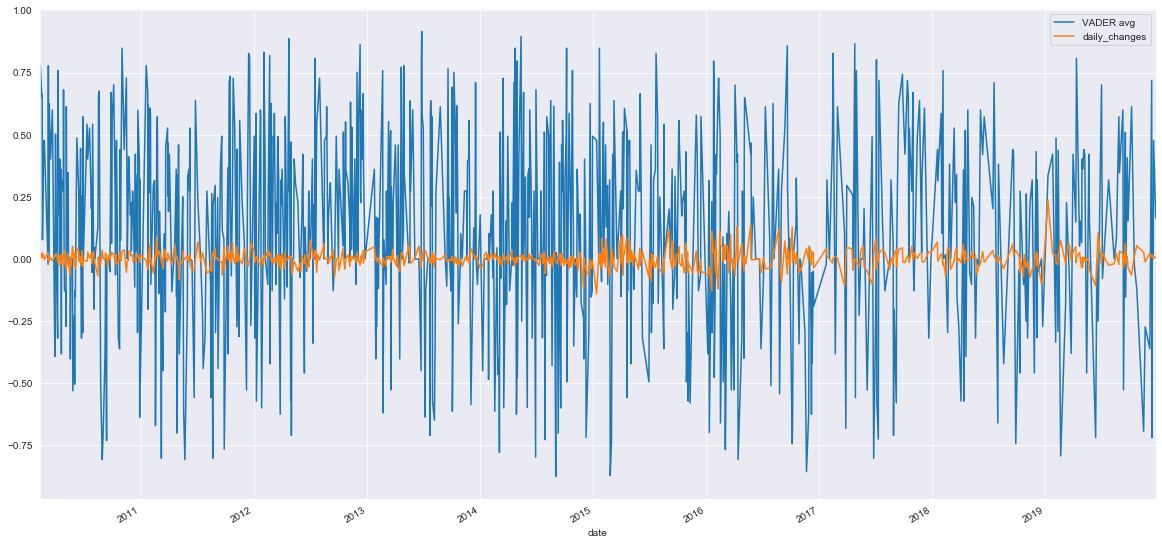

In [56]:
merged_df[['VADER avg', 'daily_changes']].plot(figsize=(20,10))

In [28]:
correlation = merged_df.corr()

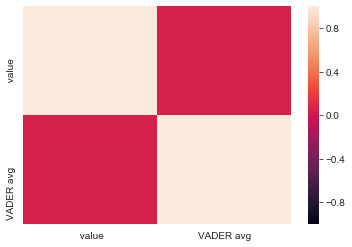

In [29]:
sns.heatmap(correlation, vmin=-1, vmax=1)

In [30]:
correlation

value  VADER avg
 value     1.000000   0.052158
VADER avg  0.052158   1.000000